In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import modules and initial setups

In [29]:
import sys
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [30]:
torch.manual_seed(123456)

In [31]:
# check the device
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print('You are using PyTorch version:', torch.__version__, 'Device:', DEVICE)

You are using PyTorch version: 2.1.0+cu121 Device: cpu


In [32]:
# batch and epoch sizes
BATCH_SIZE = 64
EPOCHS = 10

# Data augmentation

In [33]:
# CIFAR-10 data download with data augmentation
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                 train = True,
                                 download = True,
                                 transform = transforms.Compose([
                                     transforms.RandomHorizontalFlip(),       # flip horizontally with 50% probability
                                     transforms.ToTensor(),                   # [0,255] -> [0,1] tensors
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))   # normalization with a mean of 0.5 and stdev of 0.5 for RGB
                                 ]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [34]:
# check the data set, sizes and types
for (X_train, y_train) in train_loader:
  print('X_train:', X_train.size(), 'type:', X_train.type())
  print('y_train:', y_train.size(), 'type:', y_train.type())
  break

X_train: torch.Size([64, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([64]) type: torch.LongTensor


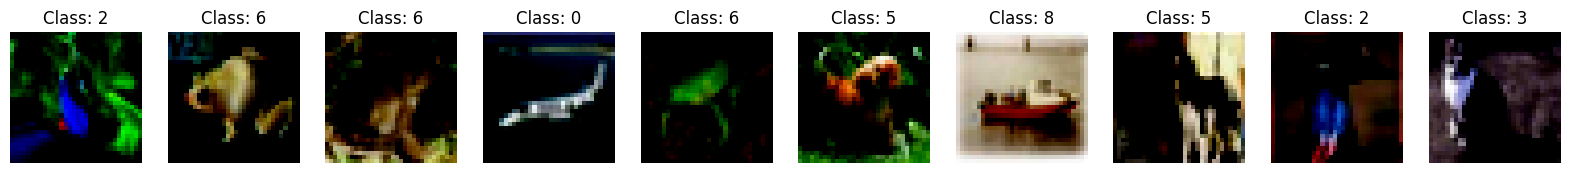

In [35]:
# check the data set, images
pltsize = 2
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(np.transpose(X_train[i], (1,2,0)))   # pytorch: (channel, height, width) -> imshow: (height, width, channel)
  plt.title('Class: ' + str(y_train[i].item()));

# ResNet model

In [36]:
# ResNet model design
class BasicBlock(nn.Module):
  def __init__(self, in_planes, planes, stride = 1):
    super(BasicBlock, self).__init__()
    # in_planes: the number of input channels
    # planes: the number of output channels
    # kernel size: 3 x 3

    # convolutional layer 1
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
    self.bn1 = nn.BatchNorm2d(planes)

    # convolutional layer 2
    self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
    self.bn2 = nn.BatchNorm2d(planes)

    # shortcut layer
    if stride != 1 or in_planes != planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, planes, kernel_size = 1, stride = stride, bias = False),
          nn.BatchNorm2d(planes))
    else:
      self.shortcut = nn.Sequential()

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, num_classes = 10):
    super(ResNet, self).__init__()
    self.in_planes = 16     # input_channel = 16

    # convolutional layer 1: (3, 32, 32) -> (16, 32, 32)
    self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1, bias = False)
    self.bn1 = nn.BatchNorm2d(16)
    self.layer1 = self._make_layer(16, 2, stride = 1)     # input_channel = 16, output_channel = 16
    self.layer2 = self._make_layer(32, 2, stride = 2)     # input_channel = 16, output_channel = 32, the output size will decrease in half as the stride is 2
    self.layer3 = self._make_layer(64, 2, stride = 2)     # input_channel = 32, output_channel = 64
    self.linear = nn.Linear(64, num_classes)

  def _make_layer(self, planes, num_blocks, stride):
    # the given stride value will be used at first, then all stride values will be 1
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(BasicBlock(self.in_planes, planes, stride))
      self.in_planes = planes
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))   # size after the layer: (64, 16, 32,32)
    # print("after first layer:", out.size())
    out = self.layer1(out)                  # (64, 16, 32, 32)
    # print("after second layer:", out.size())
    out = self.layer2(out)                  # (64, 32, 16, 16)
    # print("after third layer:", out.size())
    out = self.layer3(out)                  # (64, 64, 8, 8)
    # print("after fourth layer:", out.size())

    # average pooling
    out = F.avg_pool2d(out, 8)              # (64, 64, 1, 1)
    # print("after avg_pool2d:", out.size())
    out = out.view(out.size(0),-1)          # (64, 64)
    # print("after view:", out.size())
    out = self.linear(out)                  # (64, 10)
    # print("Final output:", out.size())
    # sys.exit()

    return out


In [37]:
# optimizer and objective function
model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [38]:
# training function
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)

    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
          epoch, batch_idx * len(image),
          len(train_loader.dataset), 100 * batch_idx / len(train_loader),
          loss.item()))

  return loss.item()

In [39]:
# testing function
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)

      output = model(image)

      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      # print("prediction size:", prediction.size())
      # print("label size:", label.size())
      # print("prediction:", prediction)
      # print("label:", label)
      # sys.exit()
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
  test_accuracy = 100 * correct / len(test_loader.dataset)

  return test_loss, test_accuracy

In [40]:
# train & test ResNet

for epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
      epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.407028
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.267287
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.160879
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.244518

[EPOCH: 1], 	Test Loss: 1.1008, 	Test Accuracy: 60.62 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 0.968067
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 0.874566
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.933021
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 0.832427

[EPOCH: 2], 	Test Loss: 1.0080, 	Test Accuracy: 65.19 % 

Train Epoch: 3 [0/50000 (0%)]	Train Loss: 0.991139
Train Epoch: 3 [12800/50000 (26%)]	Train Loss: 0.855851
Train Epoch: 3 [25600/50000 (51%)]	Train Loss: 0.876923
Train Epoch: 3 [38400/50000 (77%)]	Train Loss: 0.809511

[EPOCH: 3], 	Test Loss: 0.7916, 	Test Accuracy: 72.62 % 

Train Epoch: 4 [0/50000 (0%)]	Train Loss: 0.716119
Train Epoch: 4 [12800/50000 (26%)]	Train Loss: 0.854316
Train Epoch: 4 [25600/50000 (51%)]	Train Loss: 0.677489
Tra